In [99]:
import numpy as np

yg,xg = np.mgrid[1:80, 1:120]
x0,y0=60., 40.
sigma = 10.
data = np.exp(-((xg-x0)**2+(yg-y0)**2)/2/sigma**2)
data = (data*255.).astype('uint8')

f = StringIO()
PIL.Image.fromarray(data).save(f, 'png')
imgb64v = base64.b64encode(f.getvalue())

In [13]:
import numpy as np
import ipywidgets as ipyw
from IPython.display import display, HTML, clear_output
from cStringIO import StringIO
import PIL.Image, base64
from traitlets import Unicode, Integer, Float, HasTraits, observe
import sys

class ImageSlider(ipyw.DOMWidget):
    """The backend python class for the custom ImageSlider widget.
    
    This class declares and initializes all of the data that is synced between the front- and back-ends of the widget code.
    It also provides the majority of the calculation-based code that runs the ImageSlider widget."""
    
    _view_name = Unicode("ImgSliderView").tag(sync=True)
    _view_module = Unicode("imgslider").tag(sync=True)
    
    _format = Unicode("png").tag(sync=True)
    _b64value = Unicode().tag(sync=True)
    series_max = Integer().tag(sync=True)
    img_min = Float().tag(sync=True)
    img_max = Float().tag(sync=True)
    nrows = Integer().tag(sync=True)
    ncols = Integer().tag(sync=True)
    width = Integer().tag(sync=True)
    height = Integer().tag(sync=True)
    err = Unicode().tag(sync=True)
    offsetX = Integer().tag(sync=True)
    offsetY = Integer().tag(sync=True)
    pix_val = Float().tag(sync=True)
    img_change_trig = Integer(0).tag(sync=True)
    display_trig = Integer(0).tag(sync=True)
    css_trig = Integer(0).tag(sync=True)
    
    
    def __init__(self, image_series, width, height):
        """Constructor method for setting the necessary member variables that are synced between the front- and back-ends.
        
        Parameters:
        
            *image_series: a list of ImageFile objects (see https://github.com/ornlneutronimaging/iMars3D/blob/master/python/imars3d/ImageFile.py for more details). This list is used to give the widget access to the images that are to be viewed.
            *width: an integer that is used to set the width of the image and UI elements.
            *height: an integer that is used to set the height of the image and UI elements."""
        
        self.image_series = image_series
        self.width = width
        self.height = height
        self.series_max = len(self.image_series) - 1
        self.current_img = self.image_series[self.img_change_trig]
        arr = self.current_img.data
        self.nrows, self.ncols = arr.shape
        self.img_min, self.img_max = int(np.min(arr)), int(np.max(arr))
        self.update_image(s);
        self.set_css(s);
        super(ImageSlider, self).__init__()
        return
    
    #This function is called when the values of offsetX and/or offsetY change.
    @observe("offsetX", "offsetY")
    def get_val(self, change):
        """Tries to calculate the value of the image at the mouse position and store the result in the member variable pix_val
        
        If an error occurs, this method calls the handle_error method and stores the result in the member variable err."""
        
        try:
            arr = self.current_img.data
            #nrows, ncols = arr.shape
            col = int(self.offsetX*1./self.width * self.ncols)
            row = int(self.offsetY*1./self.height * self.nrows)
            if col >= arr.shape[1]: col = arr.shape[1]-1
            if row >= arr.shape[0]: row = arr.shape[0]-1
            self.pix_val = arr[col, row]
            self.err = ""
        except Exception:
            self.err = self.handle_error()
            return
    
    def getimg_bytes(self):
        """Encodes the data for the currently viewed image into Base64.
        
        If img_min and/or img_max have been changed from their default values, this function will also change the image data to account for this change before encoding the data into Base64."""
        
        arr = self.current_img.data.copy()
        arr[arr<self.img_min] = 0
        arr[arr>self.img_max] = self.img_max
        img = ((arr-self.img_min)/(self.img_max-self.img_min)*(2**15-1)).astype('int32')
        f = StringIO()
        PIL.Image.fromarray(img).save(f, self._format)
        imgb64v = base64.b64encode(f.getvalue())
        return imgb64v

    def handle_error(self):
        """Creates and returns a custom error message if an error occurs in the get_val method."""
        
        cla, exc, tb = sys.exc_info()
        ex_name = cla.__name__
        try:
            ex_args = exc.__dict__["args"]
        except KeyError:
            ex_args = ("No args",)
        ex_mess = str(ex_name)
        for arg in ex_args:
            ex_mess = ex_mess + str(arg)
        return(ex_mess)
    
    #This function is called when img_change_trig, img_min, and/or img_max change
    @observe("img_change_trig", "img_min", "img_max")
    def update_image(self, s):
        """The function that begins any change to the displayed image.
        
        If it is triggered by a change in img_change_trig, it changes the current_img member variable to the new desired image.
        
        In all cases, this function calls the getimg_bytes method to obtain the new Base64 encoding (of either the new or old image) and stores this encoding in _b64value."""
        
        self.current_img = self.image_series[self.img_change_trig]
        self._b64value = self.getimg_bytes()
        return
    
    def set_css(self, s):
        """Creates the CSS classes that are used to format the HTML flexboxes and flexitems used to store the UI on screen.
        Done on the backend to allow the boxes to be sized according to the width and height values provided in the constructor."""
        
        display(HTML("""
        <html>
        <style type="text/css">
        .flex-container {
            display: -webkit-flex;
            display: flex;
            justify-content: flex-start;
            width: 1000px;
            height: %spx;
        }
    
        .flex-item-img {
            width: %spx;
            height: %spx;
            padding: 5px;
        }
        
        .flex-item-data {
            width: %spx;
            height: %spx;
            padding: 5px;
        }""" 
            %(str(self.height * 1.3), str(self.width * 1.1), str(self.height * 1.25), str(1000 - self.width * 1.1 - 25), 
              str(self.height * 1.25))))
        return

In [14]:
%%javascript
require.undef("imgslider");

define("imgslider", ["jupyter-js-widgets"], function(widgets) {
   var ImgSliderView = widgets.DOMWidgetView.extend({
       //Overrides the default render method to allow for custom widget creation
       render: function() {
           //Sets all the values needed for creating the sliders. wid is created to allow model values to be obtained in functions within this render function.
           var wid = this;
           var img_max = this.model.get("series_max");
           var vrange_min = this.model.get("img_min");
           var vrange_max = this.model.get("img_max");
           var vrange_step = (vrange_max - vrange_min)/100;
           var vrange = [vrange_min, vrange_max];
           /*Creates the flexbox that will store the widget and the two flexitems that it will contain.
             img_vbox stores the image and the horizontal (Image Selector) slider.
             data_vbox stores the html text element (displays the XY coordinates of the mouse and that position's value) and the vertical (Z range) slider.*/
           var widget_area = $("<div>"); widget_area.addClass("flex-container");
           var img_vbox = $("<div>"); img_vbox.addClass("flex-item-img img-box");
           var data_vbox = $("<div>"); data_vbox.addClass("flex-item-data data-box");
           console.log(img_vbox);
           //Adds the img_vbox and data_vbox to the overall flexbox.
           widget_area.append(img_vbox);
           widget_area.append(data_vbox);
           //Adds the widget to the display area.
           this.$el.append(widget_area);
           
           //Creates the image stored in the initial value of _b64value and adds it to img_vbox.
           var img = $("<img>");
           var image_src = "data:image/" + this.model.get("_format") + ";base64," + this.model.get("_b64value")
           img.attr("src", image_src);
           img.addClass("curr-img");
           img.css("margin", "10px");
           img.width(this.model.get("width")); img.height(this.model.get("height"));
           img_vbox.append(img);
           
           //Creates a read-only input field with no border to dynamically display the value of the horizontal slider.
           var hslide_label = $('<input type="text" readonly style="border:0">'); 
           hslide_label.attr("id", "hslabel");
           //Creates the horizontal slider using JQuery UI
           var hslide_html = $('<div>'); hslide_html.addClass("hslider");
           hslide_html.slider(
           {
               value: 0,
               min: 0,
               max: img_max,
               /*When the handle slides, this function is called to update hslide_label 
               and change img_change_trig on the backend (triggers the update_image function on the backend)*/
               slide: function(event, ui) {
                   hslide_label.val( ui.value );
                   console.log("Executed!");
                   wid.model.set("img_change_trig", ui.value);
                   wid.touch();
               }
            });
           //Sets the label's initial value to the initial value of the slider
           hslide_label.val(hslide_html.slider("value"));
           //Adds hslide_html (the slider) and hslide_label (the label) to img_vbox
           img_vbox.append(hslide_html);
           img_vbox.append(hslide_label);
           console.log(hslide_html);
           
           console.log(img_vbox);
           console.log("done with img box");
           
           //Creates the fields (divs and spans) for the current mouse position and that position's value and adds them to data_vbox.
           var text_content = $("<div>"); text_content.addClass("widget-html-content");
           var xy = $("<div>"); xy.text("X,Y: ");
           var x_coord = $("<span>"); x_coord.addClass("img-offsetx");
           var y_coord = $("<span>"); y_coord.addClass("img-offsety");
           xy.append(x_coord); xy.append(", "); xy.append(y_coord);
           var value = $("<div>"); value.text("Value: ");
           var val = $("<span>"); val.addClass("img-value");
           value.append(val);
           text_content.append(xy); text_content.append(value);
           data_vbox.append(text_content);
           console.log(data_vbox);
           
           //Creates the label for the vertical slider with a static value of "Z range" (done in the same way as the other label)
           var vslide_label = $('<input type="text" readonly style="border:0">'); vslide_label.attr("id", "vs-label");
           vslide_label.val("\n\nZ range");
           vslide_label.css("paddingBottom", "10px");
           //Creates the vertical slider using JQuery UI
           var vslide_html = $("<div>"); vslide_html.addClass("vslider");
           vslide_html.slider({
               range: true,
               orientation: "vertical",
               min: vrange_min,
               max: vrange_max,
               values: vrange,
               step: vrange_step,
               /*When either handle slides, this function sets img_min and/or img_max on the backend to the handles' values.
               This triggers the update_image function on the backend.*/
               slide: function(event, ui) {
                   wid.model.set("img_min", ui.values[0]);
                   wid.model.set("img_max", ui.values[1]);
                   wid.touch();
               }
           });
           
           //Adds vslide_label and vslide_html to data_vbox. At this point, the widget can be successfully displayed.
           vslide_html.height(this.model.get("height") * 0.75);
           console.log(vrange_step);
           data_vbox.append(vslide_label);
           data_vbox.append(vslide_html);
           console.log(data_vbox);
           console.log("done with data box");
           
           /*This function sets offsetX and offsetY on the backend to the event-specific offset values whenever
           the mouse moves over the image. It then calculates the data-based XY coordinates and displays them
           in the x_coord and y_coord span fields.*/
           img.mousemove(function(event){
               wid.model.set("offsetX", event.offsetX);
               wid.model.set("offsetY", event.offsetY);
               wid.touch();
               x_coord.text(Math.floor(event.offsetX*1./(wid.model.get("width"))*(wid.model.get("ncols"))));
               y_coord.text(Math.floor(event.offsetY*1./(wid.model.get("height"))*(wid.model.get("nrows"))));
           });
           
           //Triggers on_pixval_change and on_img_change when the backend values of pix_val and _b64value change.
           this.model.on("change:pix_val", this.on_pixval_change, this);
           this.model.on("change:_b64value", this.on_img_change, this);
       },
       /*If there is no custom error message, this function sets the value of the img-value span field to
       the value of pix_val from the backend. Otherwise, it sets the value of this field to the value of
       err (the error message).*/
       on_pixval_change: function() {
           if (this.model.get("err") == "") {
               this.$el.find(".img-value").text(this.model.get("pix_val"));
           }
           else {
               this.$el.children(".img-value").text(this.model.get("err"));
           }
       },
       /*When _b64value changes on the backend, this function creates a new source string for the image (based
       on the new value of _b64value). This new source then replaces the old source of the image.*/
       on_img_change: function() {
           console.log("Changing Image");
           var src = "data:image/" + this.model.get("_format") + ";base64," + this.model.get("_b64value");
           this.$el.find(".curr-img").attr("src", src);
       }
   });
    
    //Allows the widget to be rendered
    return {
        ImgSliderView : ImgSliderView    
    };
});

<IPython.core.display.Javascript object>

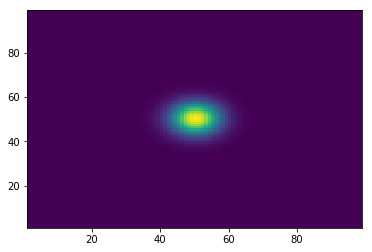

In [15]:
import numpy as np

from matplotlib import pyplot as plt
%matplotlib inline

xg,yg = np.mgrid[1:100, 1:100]

class Image:
    def __init__(self, x0, y0, sigma):
        self.data = np.exp(-((xg-x0)**2+(yg-y0)**2)/2/sigma**2)

images = [Image(50., 50., s) for s in np.arange(5, 30, 1.)]

plt.pcolormesh(xg, yg, images[0].data)

In [16]:
is1 = ImageSlider(images, 500, 500)
is1

/home/qil/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:86: RuntimeWarning: divide by zero encountered in divide
/home/qil/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:86: RuntimeWarning: invalid value encountered in divide


In [22]:
help(is1.set_css)

Help on method set_css in module __main__:

set_css(self, s) method of __main__.ImageSlider instance
    Creates the CSS classes that are used to format the HTML flexboxes and flexitems used to store the UI on screen.
    Done on the backend to allow the boxes to be sized according to the width and height values provided in the constructor.



In [251]:
           /*var hslide_container = $("<div>"); hslide_container.addClass("slider-container");
           var hslider = $("<div>"); hslider.addClass("ui-slider ui-corner-all ui-widget ui-widget-content slider ui-slider-horizontal");
           var hslider_handle = $("<span>"); hslider_handle.addClass("ui-slider-handle ui-corner-all ui-state-default");
           hslider_handle.attr("tabindex", 0); hslider_handle.attr("style", "left: 0%;");
           hslider.append(hslider_handle);
           var hslider_label = $("<div>"); hslider_label.addClass("widget-readout"); hslider_label.attr("style", ""); hslider_label.attr("contenteditable", "true");
           hslider_label.textContent(0);
           hslide_container.append(hslider); hslide_container.append(hslider_label);
           img_vbox.append(hslide_container);*/
           var text_content = $("<div>"); text_content.addClass("widget-html-content");
           var xy = $("<div>"); xy.text("X,Y:&nbsp;");
           var x_coord = $("<span>"); x_coord.addClass("img-offsetx");
           var y_coord = $("<span>"); y_coord.addClass("img-offsety");
           xy.append(x_coord); xy.append(",&nbsp;"); xy.append(y_coord);
           var value = $("<div>"); value.text("Value:&nbsp");
           var val = $("<span>"); val.addClass("img-value");
           value.append(val);
           text_content.append(xy); text_content.append(value);
           data_vbox.append(text_content);
           console.log(data_vbox);
           var vslider_vals = [this.model.get("img_min"), this.model.get("img_max")];
           var slider_max = wid.model.get("img_max");
           var slider_min = wid.model.get("img_min");
           $("#vslider").slider({
               min: slider_min,
               max: slider_max,
               value: vslider_vals,
               step: (slider_max - slider_min)/100,
               slide: function(event, ui) {
                   wid.model.set("img_min", $("#vslider").values(0));
                   wid.model.set("img_max", $("#vslider").values(1));
                   wid.touch();
               }
           });
           var vslide_label = $("<input>"); vslide_label.attr("type", "text"); vslide_label.attr("id", "vs-label");
           var vslide_html = $("<div>"); vslide_html.attr("id", "vslider");
           data_vbox.append(vslide_label);
           data_vbox.append(vslide_html);
           console.log(data_vbox);
           /*var vslide_hold = $("<div>");
           var vslider_label = $("<div>"); vslider_label.addClass("widget-label"); vslider_label.attr("style", ""); vslider_label.attr("title", "Z range"); vslider_label.textContent("Z range");
           var vslide_container = $("<div>"); vslide_container.addClass("slider-container");
           var vslider = $("<div>"); vslider.addClass("ui-slider ui-corner-all ui-widget ui-widget-content slider ui-slider-vertical");
           var vslider_bhandle = $("<span>"); vslider_bhandle.addClass("ui-slider-handle ui-corner-all ui-state-default"); vslider_bhandle.attr("tabindex", 0); vslider_bhandle.attr("style", "bottom: 0%;");
           var vslider_range = $("<div>"); vslider_range.addClass("ui-slider-range ui-corner-all ui-widget-header"); vslider_range.attr("style", "bottom: 0%; height: 100%;");
           var vslider_thandle = $("<span>"); vslider_thandle.addClass("ui-slider-handle ui-corner-all ui-state-default"); vslider_thandle.attr("tabindex", 0); vslider_thandle.attr("style", "bottom: 100%;");
           vslider.append(vslider_bhandle); vslider.append(vslider_range); vslider.append(vslider_thandle);
           vslide_container.append(vslider);
           vslide_hold.append(vslider_label); vslide_hold.append(vslide_container);
           data_vbox.append(vslide_hold);*/
           widget_area.append(img_vbox); widget_area.append(data_vbox);
           console.log(widget_area);
           this.$el.append(widget_area);
           img.mousemove(function(event){
               wid.model.set("offsetX", event.offsetX);
               wid.model.set("offsetY", event.offsetY);
               wid.touch();
               x_coord.text(Math.floor(event.offsetX*1./(wid.model.get("width"))*(wid.model.get("ncols"))));
               y_coord.text(Math.floor(event.offsetY*1./(wid.model.get("height"))*(wid.model.get("nrows"))));
           });
           this.model.on("change:pix_val", this.on_pixval_change, this);
           this.model.on("change:_b64value", this.on_img_change, this);


SyntaxError: invalid syntax (<ipython-input-251-4e00c7a74939>, line 1)